  Dataset Criterion          Pruning  TrainAcc   TestAcc
0   Data1      gini  Without Pruning       1.0  0.666667
1   Data1      gini     With Pruning       1.0  0.666667
2   Data1   entropy  Without Pruning       1.0  0.555556
3   Data1   entropy     With Pruning       1.0  0.555556
4   Data2      gini  Without Pruning       1.0  0.444444
5   Data2      gini     With Pruning       1.0  0.444444
6   Data2   entropy  Without Pruning       1.0  0.444444
7   Data2   entropy     With Pruning       1.0  0.444444

=== Actual vs Predicted (Entropy + Pruning + Data2) ===
    Actual  Predicted
21       0          1
16       1          0
3        1          0
11       0          0
19       0          0
12       1          1
10       1          1
14       0          1
6        0          1

 Correctly Predicted: 4 Out of 9
 Wrong Predictions: 5


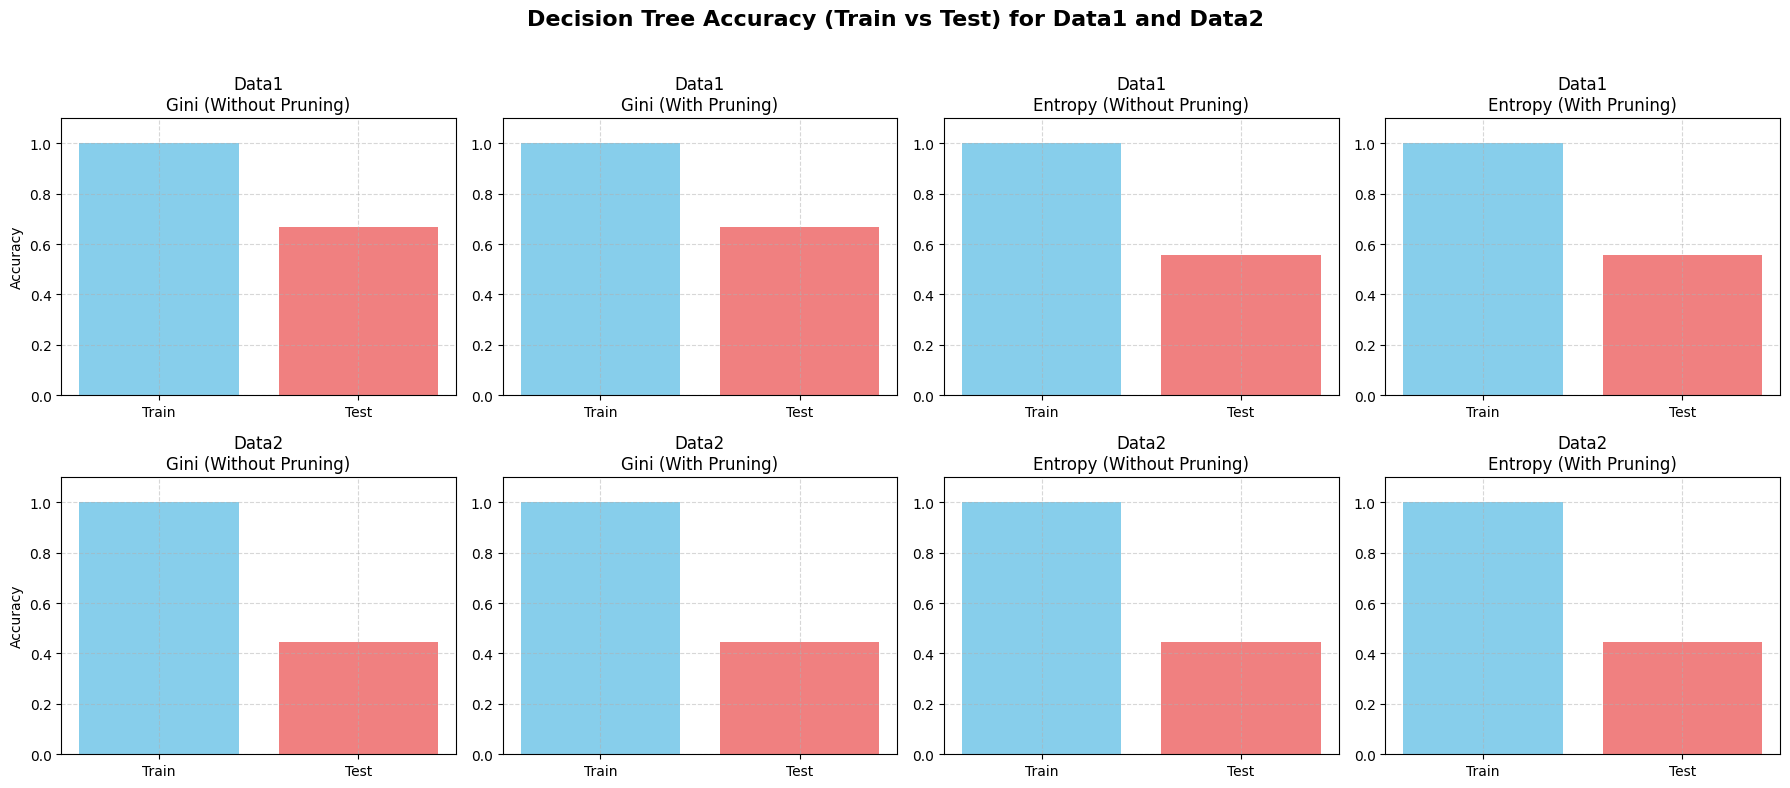

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def create_dataset():
    df = pd.DataFrame({
        f'X{i}': np.random.randint(10, 100, 30) for i in range(1, 11)
    })
    df['Y'] = np.random.randint(0, 2, 30)
    return df

data1 = create_dataset()
data2 = create_dataset()

def evaluate(df, criterion, ccp_alpha):
    X = df.drop('Y', axis=1)
    y = df['Y']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    model = DecisionTreeClassifier(criterion=criterion, ccp_alpha=ccp_alpha, random_state=42)
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    return model, X_test, y_test, train_acc, test_acc

results = []

settings = [
    ('gini', 0.0, 'Without Pruning'),
    ('gini', 0.015, 'With Pruning'),
    ('entropy', 0.0, 'Without Pruning'),
    ('entropy', 0.015, 'With Pruning')
]

datasets = {'Data1': data1, 'Data2': data2}

for name, df in datasets.items():
    for criterion, alpha, prune_type in settings:
        model, X_test, y_test, train_acc, test_acc = evaluate(df, criterion, alpha)
        results.append([name, criterion, prune_type, train_acc, test_acc, model, X_test, y_test])

table = pd.DataFrame(results, columns=['Dataset', 'Criterion', 'Pruning', 'TrainAcc', 'TestAcc', 'Model', 'X_test', 'y_test'])
print(table[['Dataset', 'Criterion', 'Pruning', 'TrainAcc', 'TestAcc']])



target_row = table[
    (table['Dataset'] == 'Data2') &
    (table['Criterion'] == 'entropy') &
    (table['Pruning'] == 'With Pruning')
].iloc[0]

model = target_row['Model']
X_test = target_row['X_test']
y_test = target_row['y_test']

y_pred = model.predict(X_test)

comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
correct = np.sum(y_test == y_pred)
wrong = len(y_test) - correct

print("\n=== Actual vs Predicted (Entropy + Pruning + Data2) ===")
print(comparison)
print(f"\n Correctly Predicted: {correct} Out of {len(y_test)}")
print(f" Wrong Predictions: {wrong}")


fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle("Decision Tree Accuracy (Train vs Test) for Data1 and Data2", fontsize=16, weight='bold')

plot_order = [
    ('gini', 'Without Pruning'),
    ('gini', 'With Pruning'),
    ('entropy', 'Without Pruning'),
    ('entropy', 'With Pruning')
]

for row_idx, dataset_name in enumerate(['Data1', 'Data2']):
    df_plot = table[table['Dataset'] == dataset_name]
    for col_idx, (criterion, prune_type) in enumerate(plot_order):
        subset = df_plot[
            (df_plot['Criterion'] == criterion) &
            (df_plot['Pruning'] == prune_type)
        ]
        ax = axes[row_idx, col_idx]
        ax.bar(['Train', 'Test'], [subset['TrainAcc'].values[0], subset['TestAcc'].values[0]], color=['skyblue', 'lightcoral'])
        ax.set_ylim(0, 1.1)
        ax.set_title(f"{dataset_name}\n{criterion.title()} ({prune_type})")
        ax.set_ylabel("Accuracy" if col_idx == 0 else "")
        ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
